In [1]:
import sklearn as sk
import os

In [2]:
path_neg_true = './database/spam/negative_polarity/truthful_from_Web'
path_neg_false = './database/spam/negative_polarity/deceptive_from_MTurk'

path_pos_true = './database/spam/positive_polarity/truthful_from_TripAdvisor'
path_pos_false = './database/spam/positive_polarity/deceptive_from_MTurk'
  
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk import ngrams
import string

def read_range(data,a,b,n, label):
    res = []
    for i in range(a,b):
        folder = 'fold'+ str(i)
        for file in os.listdir(data + "/" + folder):
             with open(data + '/' + folder + '/' + file, 'r') as content_file:
                content = content_file.read()
                res.append(content)
    return res

def read_dir(data,n, label):
  return read_range(data,1,5,n,label),read_range(data,5,6,n,label)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hrist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hrist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from nltk.classify import NaiveBayesClassifier
from sklearn.svm import SVC

scores = ['accuracy']
n=1
train_neg_true,test_neg_true = read_dir(path_neg_true,n, 'positive')
train_neg_false,test_neg_false = read_dir(path_neg_false,n,'negative')

dfTrue = pd.DataFrame(train_neg_true)
dfTrue['y'] = 1

dfFalse = pd.DataFrame(train_neg_false)
dfFalse['y'] = 0


dfTestTrue = pd.DataFrame(test_neg_true)
dfTestTrue['y']=1

dfTestFalse = pd.DataFrame(test_neg_false)
dfTestFalse['y'] = 0

frames = [dfTrue,dfFalse]
test_frames = [dfTestTrue,dfTestFalse]

df = pd.concat(frames)
test_df = pd.concat(test_frames)

#Naive Bayes classifier


In [4]:
text_clfMNB = Pipeline([ ('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])

text_clfLR = Pipeline([ ('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression(random_state=42))
])

text_clfCT = Pipeline([ ('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', tree.DecisionTreeClassifier())
])

text_clfRF = Pipeline([ ('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', ExtraTreesClassifier(random_state=42))
])

In [5]:
def run_pipeline(text_clf,parameters):
    pipe = text_clf.fit(df[0],df['y'])  
    predicted = pipe.predict(test_df[0])
    gs_clf = GridSearchCV(text_clf, parameters, cv=5)
    gs_clf = gs_clf.fit(df[0],df['y'])
    predicted = gs_clf.predict(test_df[0])
    #print(metrics.classification_report(test_df['y'], predicted))
    #print(gs_clf.best_score_)
    #print(gs_clf.best_estimator_)
    
    return gs_clf.best_estimator_

In [6]:
parameters_MNB = {
               'vect__ngram_range': [(1, 1), (2, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
}

parameters_DT = {
               'vect__ngram_range': [(1, 1), (2, 2)],
               'tfidf__use_idf': (True, False),
}

parameters_LR = {
               'vect__ngram_range': [(1, 1), (2, 2)],
               'tfidf__use_idf': (True, False),
                'clf__C': [1,0.1,0.001,0.0001],
}

parameters_RF = {
               'vect__ngram_range': [(1, 1), (2, 2)],
               'tfidf__use_idf': (True, False),
               'clf__n_estimators' : [100, 200, 300],
               'clf__max_depth' : [2,3,4,5]
}

In [7]:
print('-------Naive Bayes--------')
run_pipeline(text_clfMNB,parameters_MNB)

-------Naive Bayes--------


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...lse,
         use_idf=False)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [8]:
print('--------Dec. Trees------')
best_tree = run_pipeline(text_clfCT,parameters_DT)

--------Dec. Trees------


-------Random forests------
26
1. feature 5 (0.017221)
2. feature 23 (0.010527)


TypeError: only integer scalar arrays can be converted to a scalar index

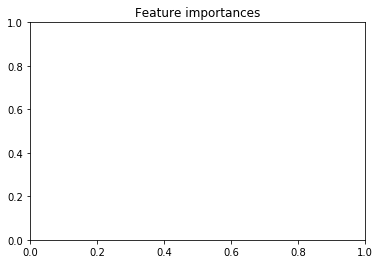

In [43]:
print('-------Random forests------')
import matplotlib.pyplot as plt
import numpy as np
#best_forest = run_pipeline(text_clfRF,parameters_RF)

best_forest = run_pipeline(text_clfRF,{})
forest = best_forest.steps[len(best_forest.steps)-1][1]

importante = forest.feature_importances_
importances = [x for x in importante if x > 0.003]
print(len(importances))
X = test_df

if len(importances) < 100:
    
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
else:
    print('too much')


In [235]:
print('--------Logistic regression-------')
run_pipeline(text_clfLR, parameters_LR)

--------Logistic regression-------


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])